<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2024_03_07_jax_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutions in JAX

## Acknowledgment:
This tutorial was very helpful [Generalized Convolutions in JAX](https://jax.readthedocs.io/en/latest/notebooks/convolutions.html). I borrowed some code from that tutorial.

## Convolution functions in jax and pytorch

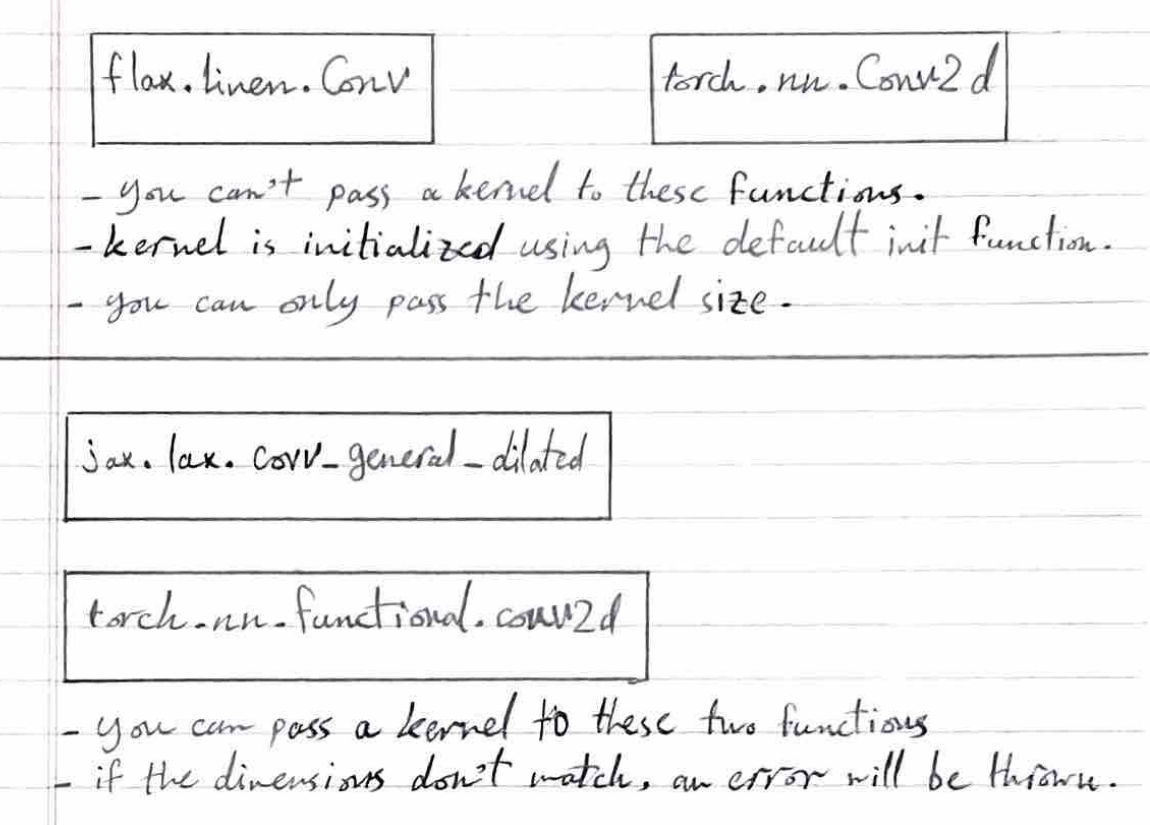

## Visualizing convolutions as matrix multiplication
Given a $32 \times 32 \times 3$ image, we are passing $4$ filters of size $5 \times 5$. For simplicity we are setting `padding = 0` and `stride = 1`. Let's compute the size of the output:

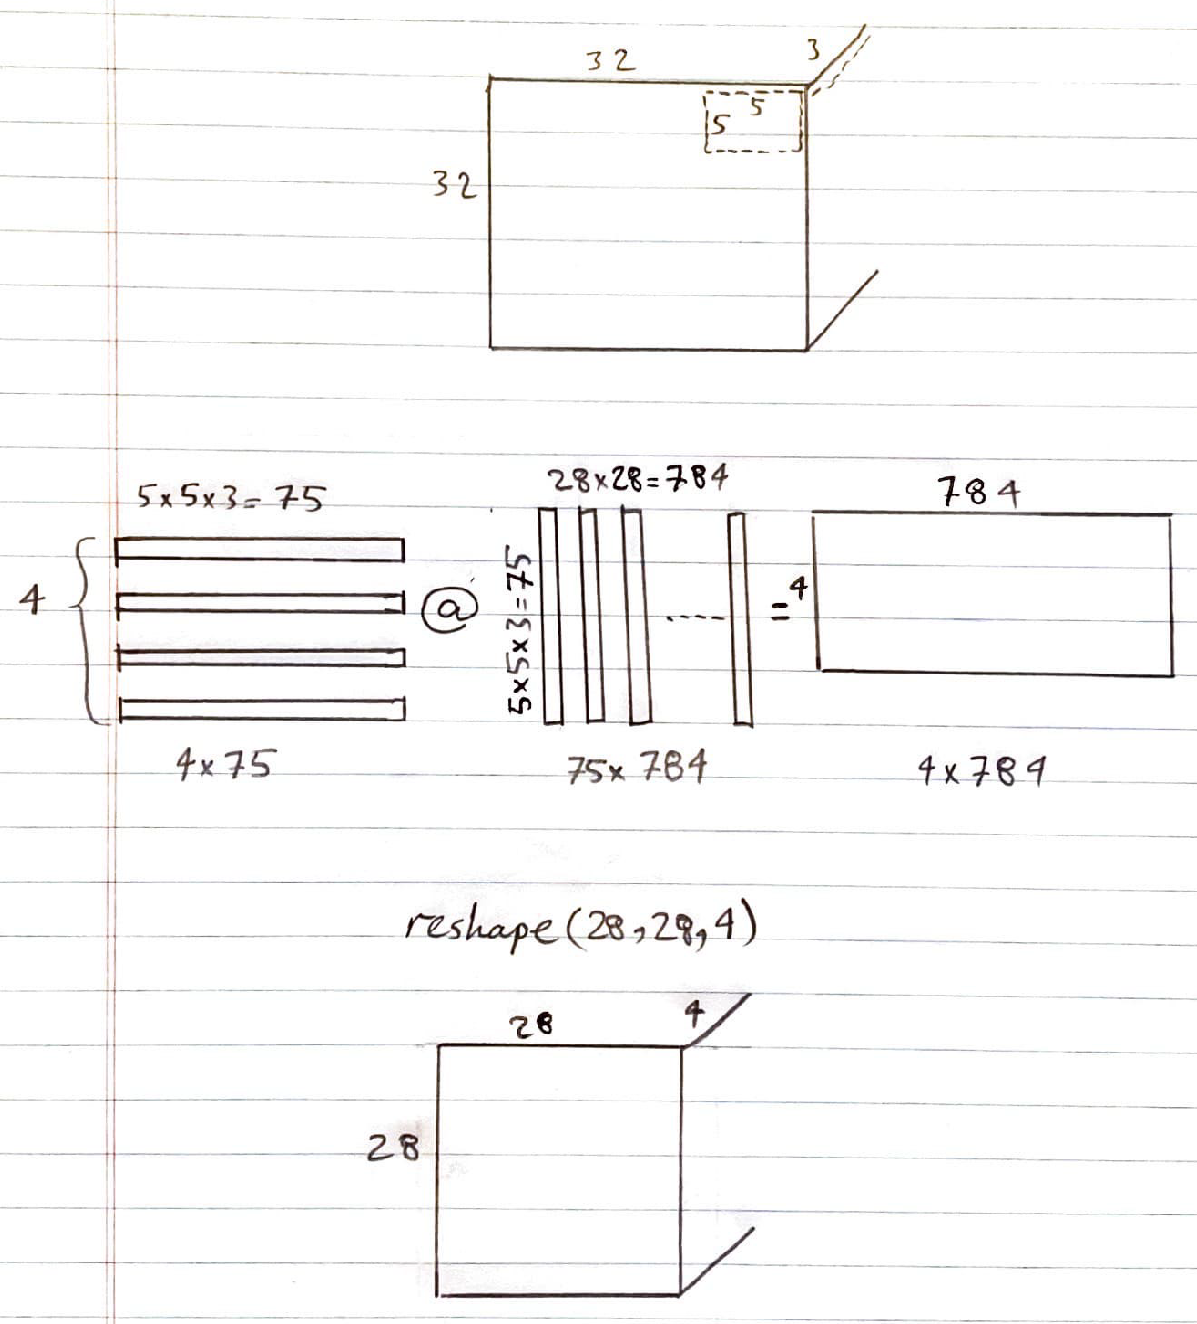

In [ ]:
# Standard libraries
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F

# torchvision
import torchvision
import torchvision.transforms as transforms

# jax
import jax
import jax.numpy as jnp
import flax
from flax import linen

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)
plt.style.use('dark_background')

## Importing CIFAR10 dataset

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# set the preprocess operations to be performed on train/val/test samples
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# download CIFAR10 test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=False)
CIFAR10_example_image = next(iter(test_loader))

Files already downloaded and verified


In [ ]:
print(f'size of images in the first batch: {CIFAR10_example_image[0].shape}')
print(f'type of images in the first batch: {CIFAR10_example_image[0].dtype}')
print(f'size of labels in the first batch: {CIFAR10_example_image[1].shape}')
print(f'type of labels in the first batch: {CIFAR10_example_image[1].dtype}')

size of images in the first batch: torch.Size([32, 3, 32, 32])
type of images in the first batch: torch.float32
size of labels in the first batch: torch.Size([32])
type of labels in the first batch: torch.int64


## Creating $4$ filters randomly

In [ ]:
kernel = jax.random.normal(jax.random.PRNGKey(random_seed), shape=(4,3,5,5))
print(f'size of kernel: {kernel.shape}')
print(f'type of kernel: {kernel.dtype}')

size of kernel: (4, 3, 5, 5)
type of kernel: float32


## Convolutions in pytorch

In [ ]:
torch_conv2d_out = F.conv2d(CIFAR10_example_image[0], torch.from_numpy(np.array(kernel)), padding='valid')

In [ ]:
print(f'size of torch output: {torch_conv2d_out.shape}')
print(f'type of torch output: {torch_conv2d_out.dtype}')

size of torch output: torch.Size([32, 4, 28, 28])
type of torch output: torch.float32


## Convolutions in jax

In [ ]:
batch_00 = jnp.asarray(CIFAR10_example_image[0])
print(f'size of images in the first batch: {batch_00.shape}')
print(f'type of images in the first batch: {batch_00.dtype}')

size of images in the first batch: (32, 3, 32, 32)
type of images in the first batch: float32


### An example on convolutions dimensions in jax

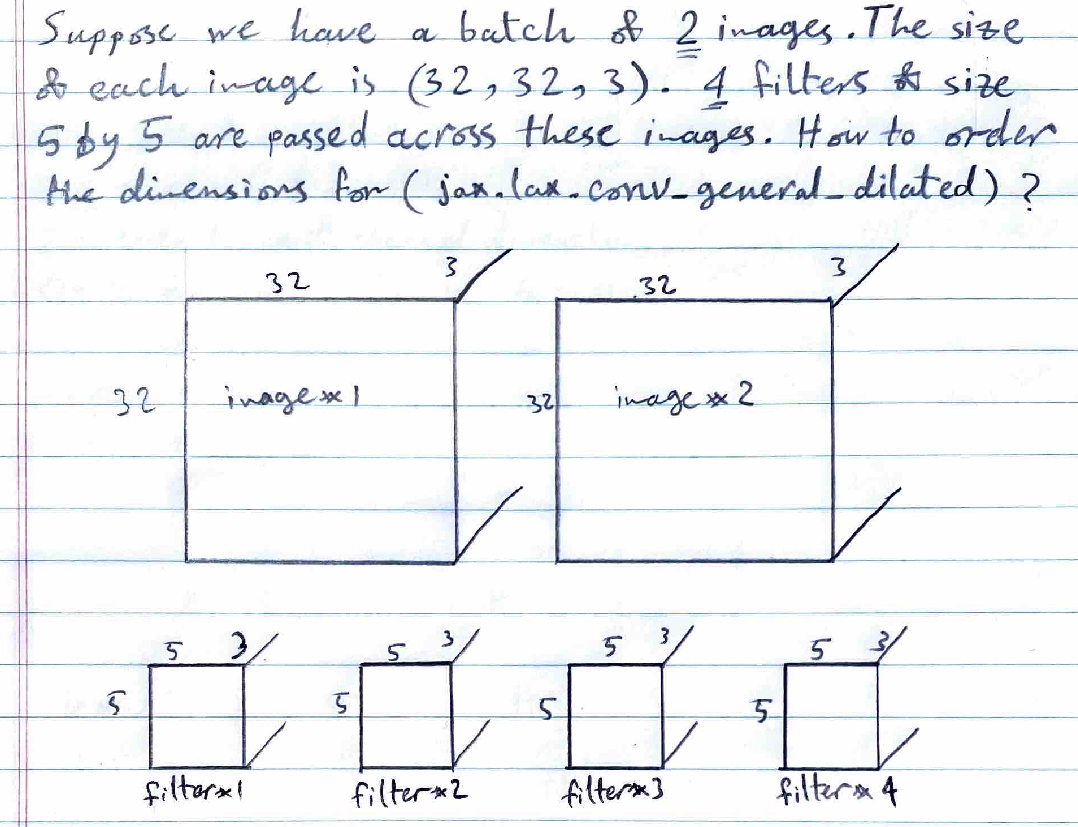

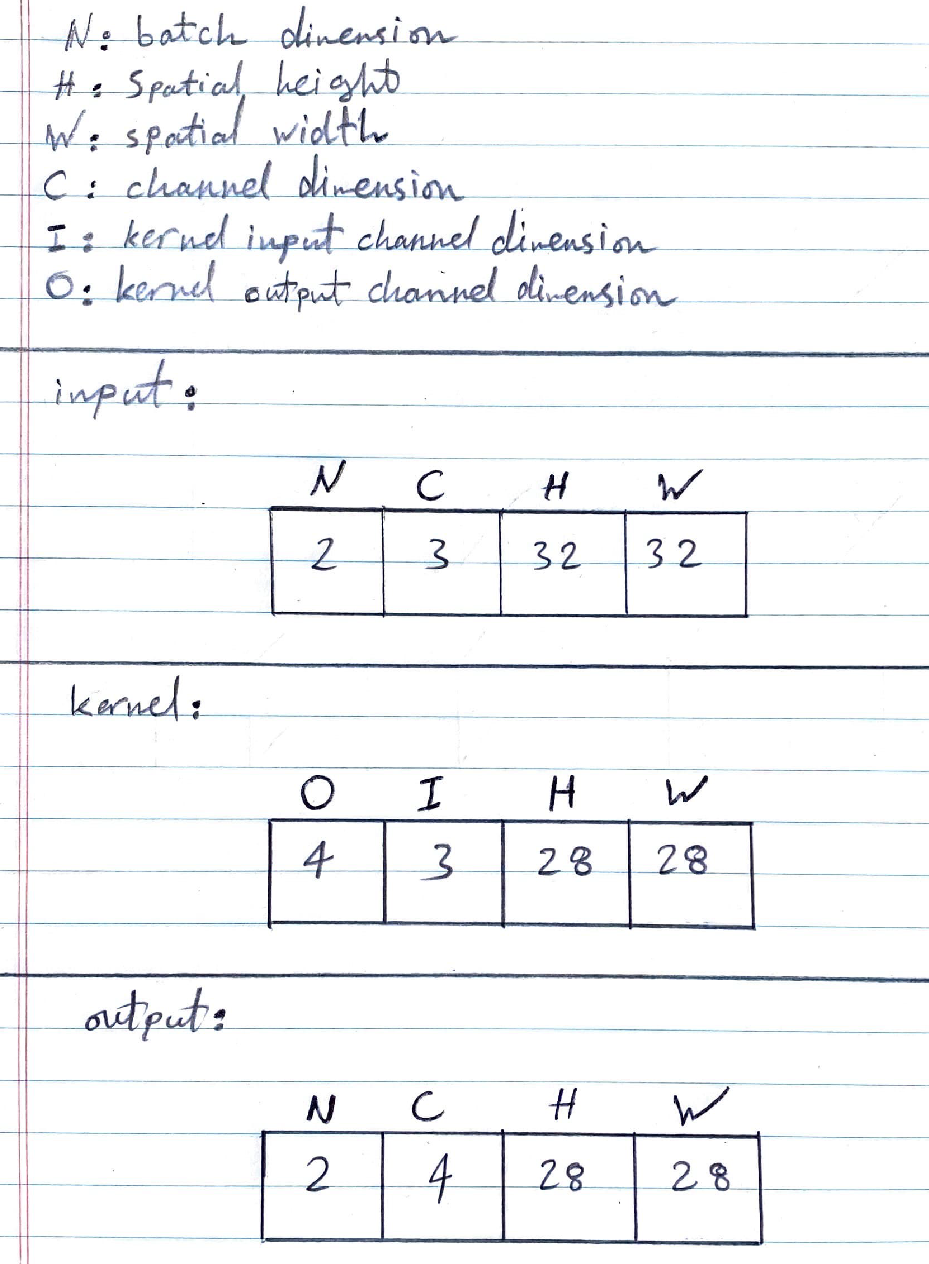

### Making sure the dimensions are right

In [ ]:
dn = jax.lax.conv_dimension_numbers(batch_00.shape,     # only ndim matters, not shape
                                    kernel.shape,       # only ndim matters, not shape
                                     ('NCHW', 'OIHW', 'NCHW'))  # the important bit
print(dn)

ConvDimensionNumbers(lhs_spec=(0, 1, 2, 3), rhs_spec=(0, 1, 2, 3), out_spec=(0, 1, 2, 3))


In [ ]:
out = jax.lax.conv_general_dilated(batch_00,     # lhs = image tensor
                               kernel,  # rhs = conv kernel tensor
                               (1,1),   # window strides
                               'VALID', # padding mode
                               (1,1),   # lhs/image dilation
                               (1,1),   # rhs/kernel dilation
                               dn)      # dimension_numbers = lhs, rhs, out dimension permutation

In [ ]:
print(f'size of flax output: {out.shape}')
print(f'type of flax output: {out.dtype}')

size of flax output: (32, 4, 28, 28)
type of flax output: float32


## Comparing the output of the two convolutions

In [ ]:
jnp.max(jnp.abs(out - jnp.asarray(torch_conv2d_out.detach())))

Array(7.6293945e-06, dtype=float32)

In [ ]:
jnp.array_equiv(out, jnp.asarray(torch_conv2d_out.detach()))

Array(False, dtype=bool)

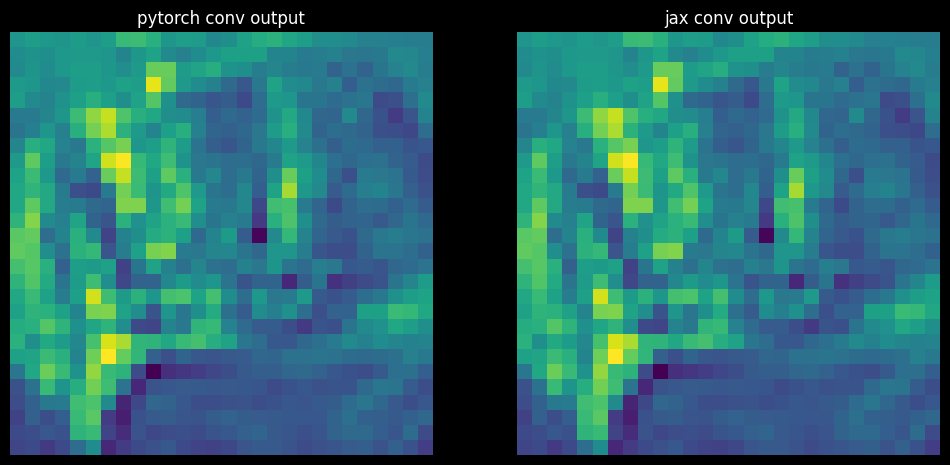

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(torch_conv2d_out[0,0,:,:].detach().numpy())
ax1.set_title('pytorch conv output')
ax1.axis("off")

ax2.imshow(out[0,0,:,:])
ax2.set_title('jax conv output')
ax2.axis("off")

plt.show()

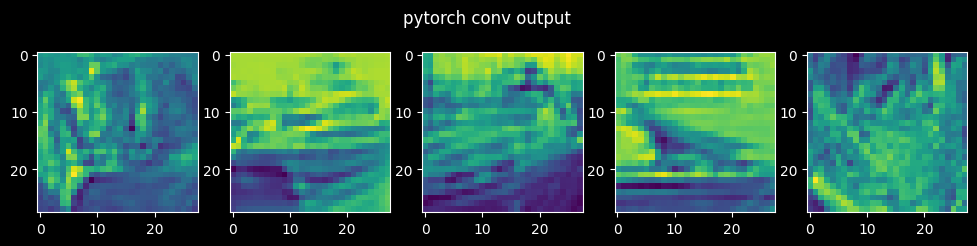

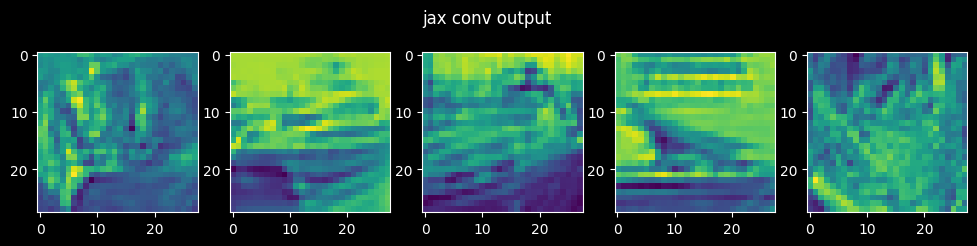

In [ ]:
num_of_images = 5

fig, axs = plt.subplots(1, num_of_images, figsize=(12, 6))
fig.suptitle('pytorch conv output', y=0.7)
for i, ax in enumerate(axs.ravel()):
  ax.imshow(torch_conv2d_out[i,0,:,:].detach().numpy())


fig, axs = plt.subplots(1, num_of_images, figsize=(12, 6))
fig.suptitle('jax conv output', y=0.7)
for i, ax in enumerate(axs.ravel()):
  ax.imshow(out[i,0,:,:])


plt.show()